<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#библиотеки" data-toc-modified-id="библиотеки-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>библиотеки</a></span></li><li><span><a href="#предобработка-фото" data-toc-modified-id="предобработка-фото-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>предобработка фото</a></span></li><li><span><a href="#создать-полигоны-аннотаций---вручную" data-toc-modified-id="создать-полигоны-аннотаций---вручную-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>создать полигоны аннотаций - вручную</a></span></li></ul></div>

## библиотеки

In [1]:
# !pip install opencv-python
# !pip install segmentation_models

import pandas as pd
import numpy as np
import os
import torch
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image, ImageOps, ImageEnhance
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2
from keras_unet_collection import models
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Переменные
epochs=30
random_state=123
test_size=0.05 
batch_size=2


# Путь к директории с фотографиями
foto_directory = r"E:\gnat\gnat_set_center"
csv_file =       r"E:\gnat\gnat_set_center\gnat_set_center.csv"  # Путь к файлу CSV

# number_dots=1

## предобработка фото

In [2]:
# # ОБРЕЗКА+ИНВЕРТИРОВАНИЕ+КОНТРАСТ

# Целевое разрешение
target_width, target_height = 690, 690

# Разрешение для изменения размера
new_width, new_height = 256, 256

# Перебор всех файлов в директории
for filename in os.listdir(foto_directory):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Проверка, что файл является изображением
        img_path = os.path.join(foto_directory, filename)
        with Image.open(img_path) as img:
            # Проверка, нужно ли обрезать изображение
            if img.size[0] > target_width or img.size[1] > target_height:
                # Обрезка по горизонтали
                total_crop_width = img.size[0] - target_width
                left_crop = total_crop_width * 0.75
                right_crop = total_crop_width * 0.25
                left = left_crop
                right = img.size[0] - right_crop

                # Обрезка по вертикали
                total_crop_height = img.size[1] - target_height
                top_crop = total_crop_height * 0.5
                bottom_crop = total_crop_height * 0.5
                top = top_crop
                bottom = img.size[1] - bottom_crop

                # Обрезка изображения
                img = img.crop((left, top, right, bottom))

            # Инвертирование цветов
#             img_inverted = ImageOps.invert(img)
            img_inverted = img

            # Увеличение контрастности
            enhancer = ImageEnhance.Contrast(img_inverted)
            img_contrasted = enhancer.enhance(1.0)  # Увеличиваем контраст на 50%
            
            # Изменение размера до 256x256
            img_resized = img_contrasted.resize((new_width, new_height))

            # Сохранение обработанного изображения, заменяя оригинал
            img_resized.save(img_path)

## создать полигоны аннотаций - вручную

In [3]:
# stop

In [4]:
# # маски (МНОГОУГОЛЬНИКА)

# # Сортировка списка файлов
# file_list = sorted([file for file in os.listdir(foto_directory) if file.lower().endswith(('.png', '.jpg', '.jpeg'))])

# # Загрузка изображений с сортировкой
# def load_images(directory, file_list):
#     images = []
#     for file in file_list:
#         img_path = os.path.join(directory, file)
#         img = load_img(img_path, color_mode='rgb')
#         img = img_to_array(img)
#         images.append(img)
#     return np.array(images)

# # Чтение данных из CSV
# df = pd.read_csv(csv_file)

# # Создание масок с сортировкой
# masks = []
# for file in file_list:
#     row = df[df['filename'] == file].iloc[0]
#     region = json.loads(row['region_shape_attributes'])
#     x_coords = region['all_points_x']
#     y_coords = region['all_points_y']
#     coords = list(zip(x_coords, y_coords))

#     # Для создания маски, мы предполагаем, что все изображения имеют одинаковый размер
#     # который является целевым разрешением (? , ?)
#     mask = np.zeros((new_height, new_width), dtype=np.uint8)
#     cv2.fillPoly(mask, [np.array(coords)], color=1)
#     masks.append(mask)

# # Конвертировать список масок в массив numpy
# masks = np.array(masks)

# # Теперь `images` и `masks` загружены в соответствии с сортированным списком файлов
# images = load_images(foto_directory, file_list)

# # Нормализация изображений
# images = images.astype('float32') / 255
# masks = masks.astype('float32')



In [5]:
# маски (КРУГА)

import numpy as np
import cv2
import os
import pandas as pd
import json
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# Сортировка списка файлов
file_list = sorted([file for file in os.listdir(foto_directory) if file.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Загрузка изображений с сортировкой
def load_images(directory, file_list):
    images = []
    for file in file_list:
        img_path = os.path.join(directory, file)
        img = load_img(img_path, color_mode='rgb')
        img = img_to_array(img)
        images.append(img)
    return np.array(images)

# Чтение данных из CSV
df = pd.read_csv(csv_file)

# Создание масок для кругов с сортировкой
masks = []
for file in file_list:
    row = df[df['filename'] == file].iloc[0]
    region = json.loads(row['region_shape_attributes'])
    
    # Убедимся, что значения координат и радиуса являются целыми числами
    cx = int(region['cx'])
    cy = int(region['cy'])
    r = int(region['r'])

    # Создание маски для круга
    mask = np.zeros((new_height, new_width), dtype=np.uint8)
    cv2.circle(mask, (cx, cy), r, color=1, thickness=-1)
    masks.append(mask)

# Конвертировать список масок в массив numpy
masks = np.array(masks)

# Теперь `images` и `masks` загружены в соответствии с сортированным списком файлов
images = load_images(foto_directory, file_list)

# Нормализация изображений
images = images.astype('float32') / 255
masks = masks.astype('float32')


# -------------------
# Создание инвертированных масок для кругов с сортировкой (с черным кругом на суставе)
inverted_masks = []
for mask in masks:
    # Инвертирование маски
    inverted_mask = 1 - mask
    inverted_masks.append(inverted_mask)

# Конвертировать список инвертированных масок в массив numpy
inverted_masks = np.array(inverted_masks)

# Теперь есть `images` и инвертированные `masks` в соответствии с сортированным списком файлов
# Нормализация инвертированных масок, 
inverted_masks = inverted_masks.astype('float32')
masks = inverted_masks


In [6]:
# Разделение данных на обучающую и тестовую выборки
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=test_size, random_state=random_state)

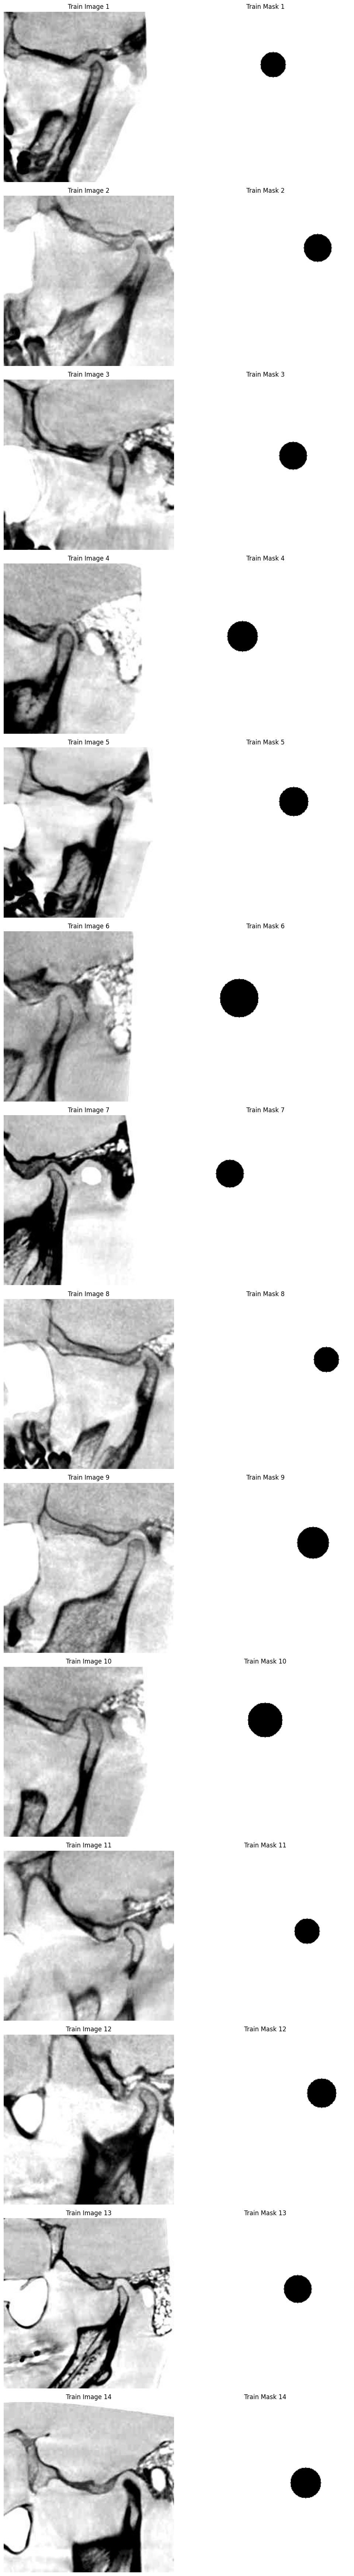

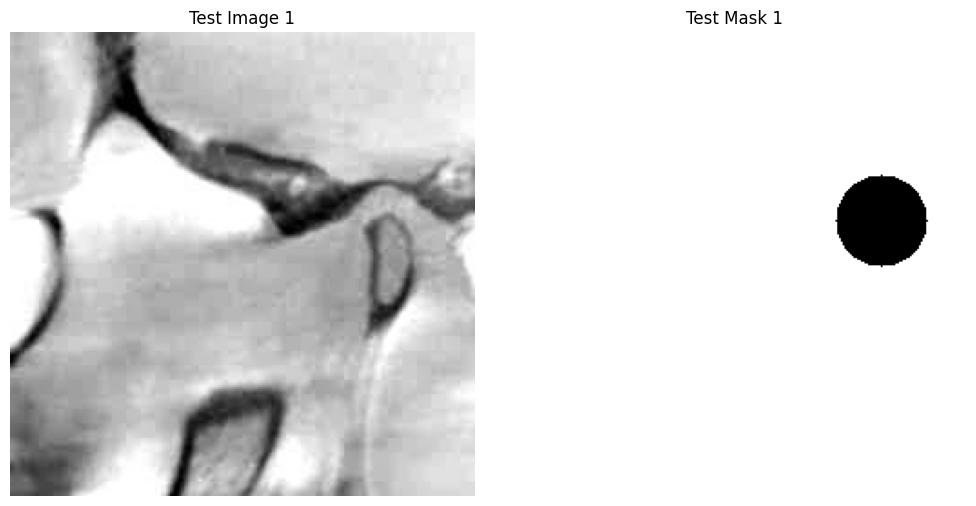

In [7]:
# Функция для отображения пар изображений и масок
def display_image_mask_pairs(images, masks, title='Train'):
    num_pairs = len(images)
    plt.figure(figsize=(5, num_pairs * 5))
    
    for i in range(num_pairs):
        plt.subplot(num_pairs, 2, i * 2 + 1)
        plt.title(f"{title} Image {i+1}")
        plt.imshow(images[i])
        plt.axis('off')

        plt.subplot(num_pairs, 2, i * 2 + 2)
        plt.title(f"{title} Mask {i+1}")
        plt.imshow(masks[i].squeeze(), cmap='gray')  # Squeeze убирает лишние измерения
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Отображение пар изображений и масок для тренировочного набора
display_image_mask_pairs(train_images, train_masks, title='Train')

# Отображение пар изображений и масок для тестового набора
display_image_mask_pairs(test_images, test_masks, title='Test')


In [8]:
# # Обучение, компиляция и тестирование модели U-Net (тут ваш код)
# # Создание модели U-Net
# model = models.unet_2d((None, None, 3), [16, 32, 64, 128, 256], n_labels=1, # 
# # model = models.unet_2d((None, None, 3), [64, 128, 256, 512, 1024], n_labels=1, # - оригинал
#                        stack_num_down=2, stack_num_up=2,
#                        activation='ReLU', output_activation='Sigmoid',
#                        batch_norm=True, pool='max', unpool='nearest', name='u-net')

# # Компиляция модели
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Обучение модели
# model.fit(train_images, train_masks, batch_size=1, epochs=30, validation_split=0.1)

# # Тестирование модели
# test_loss, test_accuracy = model.evaluate(test_images, test_masks)
# print(f"Точность на тестовых данных: {test_accuracy}")

In [9]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Функция для вычисления Dice Coefficient
def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Функция потерь Dice Loss
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# Измененная модель U-Net с использованием Dice Loss и Dice Coefficient в качестве метрики
# model = models.unet_2d((None, None, 3), [64, 128, 256, 512, 1024], n_labels=1,# оригинал
model = models.unet_2d((None, None, 3),   [32, 64, 128, 256, 512], n_labels=1,
# model = models.unet_2d((None, None, 3),   [16, 32, 64, 128, 256], n_labels=1,                       
                       stack_num_down=2, stack_num_up=2,
                       activation='ReLU', output_activation='Sigmoid',
                       batch_norm=True, pool='max', unpool='nearest', name='u-net')

# Компиляция модели с Dice Loss
model.compile(optimizer=RMSprop(), loss=dice_loss, metrics=[dice_coefficient])

# Добавление callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ModelCheckpoint('model-best.h5', verbose=1, save_best_only=True)
]

# Обучение модели с callbacks
model.fit(train_images, train_masks, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks)

# Загрузка лучшей модели и тестирование
model.load_weights('model-best.h5')
test_loss, test_dice_coefficient = model.evaluate(test_images, test_masks)
print(f"Dice Coefficient на тестовых данных: {test_dice_coefficient}")

Epoch 1/30
6/6 [==============================] - ETA: 0s - loss: 0.2121 - dice_coefficient: 0.7879
Epoch 1: val_loss improved from inf to 0.33804, saving model to model-best.h5


D:\installed\anaconda3\envs\notebook\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 17s 2s/step - loss: 0.2121 - dice_coefficient: 0.7879 - val_loss: 0.3380 - val_dice_coefficient: 0.6620
Epoch 2/30
6/6 [==============================] - ETA: 0s - loss: 0.1183 - dice_coefficient: 0.8817
Epoch 2: val_loss improved from 0.33804 to 0.30275, saving model to model-best.h5
6/6 [==============================] - 12s 2s/step - loss: 0.1183 - dice_coefficient: 0.8817 - val_loss: 0.3028 - val_dice_coefficient: 0.6972
Epoch 3/30
6/6 [==============================] - ETA: 0s - loss: 0.0891 - dice_coefficient: 0.9109
Epoch 3: val_loss improved from 0.30275 to 0.26622, saving model to model-best.h5
6/6 [==============================] - 12s 2s/step - loss: 0.0891 - dice_coefficient: 0.9109 - val_loss: 0.2662 - val_dice_coefficient: 0.7338
Epoch 4/30
6/6 [==============================] - ETA: 0s - loss: 0.0700 - dice_coefficient: 0.9300
Epoch 4: val_loss improved from 0.26622 to 0.26295, saving model to model-best.h5
6/6 [====================

1/1 [==============================] - 1s 601ms/step


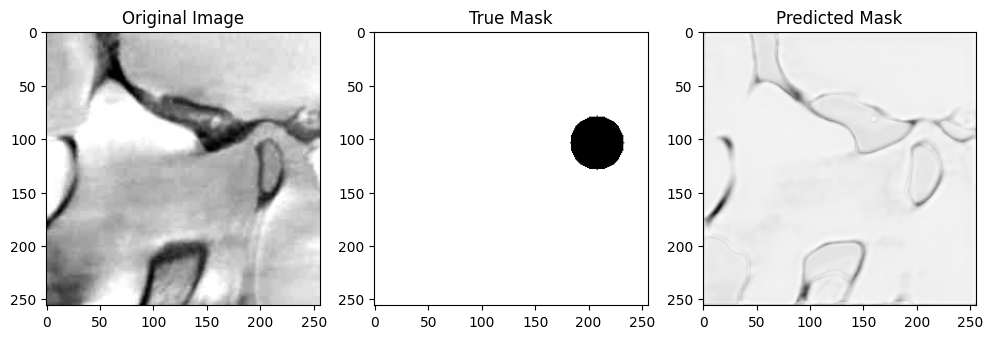

In [10]:
# Выбор случайного тестового изображения
random_index = np.random.randint(0, len(test_images))
test_image = test_images[random_index]
test_mask = test_masks[random_index]

# Предсказание сегментированной маски
predicted_mask = model.predict(np.expand_dims(test_image, axis=0))[0]

# Подготовка изображения для отображения
plt.figure(figsize=(12, 6))

# Отображение оригинального изображения
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(test_image)

# Отображение истинной маски
plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(test_mask, cmap='gray')

# Отображение предсказанной маски
plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(predicted_mask.squeeze(), cmap='gray')  # squeeze для удаления лишних измерений

plt.show()

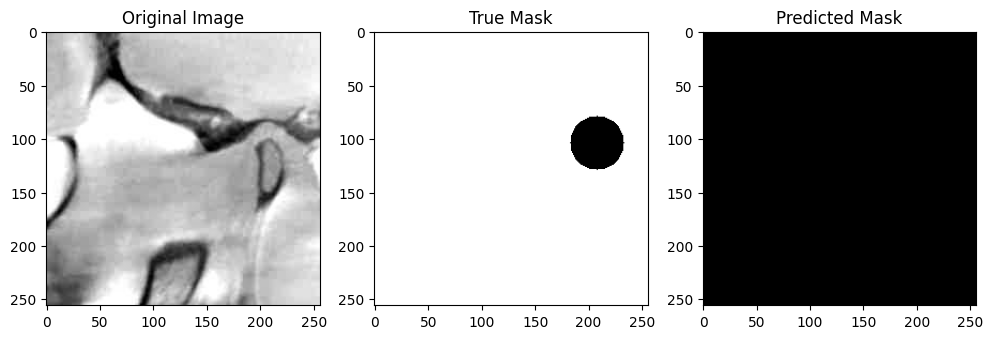

In [11]:
threshold = 0.5  # порог подобрать 
binary_mask = (predicted_mask > threshold).astype(np.uint8)  # Получаем двоичную маску


# Подготовка изображения для отображения
plt.figure(figsize=(12, 6))

# Отображение оригинального изображения
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(test_image)

# Отображение истинной маски
plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(test_mask, cmap='gray')

# Отображение предсказанной маски
plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(binary_mask.squeeze(), cmap='gray')  # squeeze для удаления лишних измерений

plt.show()